# Setup

In [1]:
# Image from Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --quiet shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.4 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import string
import re
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K

import seaborn as sns # untuk visualisasi
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# potongan kode di bawah adalah agar gambar graph yang 
# dihasilkan mempunyai kualitas yang cukup baik
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

In [4]:
abusive_lexicon = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/abusive.csv')
dataset = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/re_dataset.csv', encoding='latin-1')

eda_data = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/eda_sample.csv', encoding='latin-1')
model_data = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/model_data.csv', encoding='latin-1')

kamus_alay = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/kamusalay.csv', encoding='latin-1')
potensi_bias = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/potensi_bias.csv', encoding='latin-1')

features_df = pd.read_csv('/content/drive/MyDrive/Tugas Akhir/Data/extracted_feature.csv', encoding='latin-1')

In [5]:
features_df = features_df.loc[:, features_df.columns != 'Unnamed: 0']
features_df = features_df.loc[:, features_df.columns != 'Tweet']

# Tutorial

https://machinelearningmastery.com/feature-selection-with-numerical-input-data/

In [6]:
data = features_df.values

In [7]:
data

array([[ 0,  0,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  4,  0,  0],
       [ 0,  0,  0, ...,  6,  0,  0],
       ...,
       [ 0,  1,  0, ...,  5,  0,  1],
       [ 0,  1,  0, ..., 49,  1,  1],
       [ 0,  1,  0, ..., 12,  0,  1]])

In [8]:
X = data[:, :-1]
y = data[:,-1]

# X = features_df.loc[:, features_df.columns != 'HS']
# y = features_df.loc[:, features_df.columns == 'HS']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [10]:
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (2205, 389) (2205,)
Test (1087, 389) (1087,)


# Numerical Feature Selection

## ANOVA f-test Feature Selection

In [11]:
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=f_classif, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

In [12]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
fs_list = []
for i in range(len(fs.scores_)):
 print('Feature %s: %f' % (features_df.columns[i], fs.scores_[i]))
 if fs.scores_[i] > 0:
  fs_list.append((features_df.columns[i], fs.scores_[i]))

Feature Exclamation: 70.553716
Feature Abusive: 35.469689
Feature jokowi: 63.371016
Feature islam: 6.008949
Feature indonesia: 0.863349
Feature prabowo: 54.861089
Feature cina: 14.316204
Feature ahok: 53.125797
Feature presiden: 1.469789
Feature kpk: 10.985125
Feature gubernur: 10.152302
Feature sby: 12.227682
Feature anies: 12.227682
Feature dpr: 6.424447
Feature muslim: 1.410264
Feature sandi: 8.114390
Feature anies-sandi: 12.126958
Feature rohingya: 5.361090
Feature kristen: 17.574428
Feature buddha: 0.599057
Feature myanmar: 8.058782
Feature china: 2.654459
Feature alay: 0.016168
Feature ampas: 0.518922
Feature buta: 3.143998
Feature keparat: 12.126958
Feature anjing: 10.558504
Feature anjir: 7.868784
Feature babi: 6.060843
Feature bacot: 10.259730
Feature bajingan: nan
Feature banci: 3.242270
Feature bandot: nan
Feature buaya: 7.539119
Feature bangkai: 6.059474
Feature bangsat: 11.917097
Feature bego: 7.479306
Feature bejat: 5.113140
Feature bencong: 0.126864
Feature berak: 2.6748

Features [ 30  32  64  72  73  95 106 107 109 113 124 129 135 138 139] are constant.
invalid value encountered in true_divide


# Rank Features

## ANOVA-f

In [13]:
sorted_anova_fs = fs_list
sorted_anova_fs.sort(key = lambda i:i[1], reverse = True)
len(sorted_anova_fs)

374

In [14]:
sorted_anova_fs

[('cebong', 110.34811441960026),
 ('2019gantipresiden', 75.90069314600002),
 ('Exclamation', 70.55371595026722),
 ('jokowi', 63.371015645395964),
 ('prabowo', 54.86108861723573),
 ('ahok', 53.125796943099495),
 ('lengser', 42.777155871476005),
 ('Length', 36.84098374032803),
 ('Abusive', 35.469689057989),
 ('budaya', 34.90252416756176),
 ('tolol', 33.53126063723237),
 ('goblok', 33.463208660821344),
 ('Uppercase', 32.61247054509399),
 ('bubar', 29.583672984510986),
 ('dungu', 28.192095154682843),
 ('kampret', 25.453576436951316),
 ('bani', 25.453576436951316),
 ('dasar', 25.231513174062865),
 ('Words', 24.62759681765306),
 ('kafir', 24.564368023774918),
 ('otak', 23.521747205193947),
 ('katolik', 22.98481959802605),
 ('tipu', 21.29015625192861),
 ('bom', 21.069816411923135),
 ('biadab', 18.96557774364226),
 ('ekonomi', 18.55243737936092),
 ('kristen', 17.574428491215734),
 ('pki', 16.518813009230392),
 ('pilkada', 16.334821106469022),
 ('sontoloyo', 16.221324924819715),
 ('usir', 14.75

In [15]:
top_30_features = [sorted_anova_fs[i] for i in range(30)]

In [16]:
top_30_features

[('cebong', 110.34811441960026),
 ('2019gantipresiden', 75.90069314600002),
 ('Exclamation', 70.55371595026722),
 ('jokowi', 63.371015645395964),
 ('prabowo', 54.86108861723573),
 ('ahok', 53.125796943099495),
 ('lengser', 42.777155871476005),
 ('Length', 36.84098374032803),
 ('Abusive', 35.469689057989),
 ('budaya', 34.90252416756176),
 ('tolol', 33.53126063723237),
 ('goblok', 33.463208660821344),
 ('Uppercase', 32.61247054509399),
 ('bubar', 29.583672984510986),
 ('dungu', 28.192095154682843),
 ('kampret', 25.453576436951316),
 ('bani', 25.453576436951316),
 ('dasar', 25.231513174062865),
 ('Words', 24.62759681765306),
 ('kafir', 24.564368023774918),
 ('otak', 23.521747205193947),
 ('katolik', 22.98481959802605),
 ('tipu', 21.29015625192861),
 ('bom', 21.069816411923135),
 ('biadab', 18.96557774364226),
 ('ekonomi', 18.55243737936092),
 ('kristen', 17.574428491215734),
 ('pki', 16.518813009230392),
 ('pilkada', 16.334821106469022),
 ('sontoloyo', 16.221324924819715)]

# Logistic Regression Analysis

In [20]:
import statsmodels.formula.api as smf

In [21]:
lra_model = smf.logit("""
    HS ~
          cebong
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.649953
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.04560
Time:                        04:27:51   Log-Likelihood:                -2139.6
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 2.247e-46
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4139      0.036    -11.373      0.000      -0.485      -0.343
cebong         3.7172      0.457      8.137      0.000       2.822       4.612
==============================================================================
"""

In [74]:
lra_model = smf.logit("""
    HS ~
          Q("anies-sandi")
""", data = features_df)

results = lra_model.fit()
results.summary()

         Current function value: 0.677851
         Iterations: 35


Maximum Likelihood optimization failed to converge. Check mle_retvals


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.004628
Time:                        04:52:16   Log-Likelihood:                -2231.5
converged:                      False   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 5.226e-06
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3223      0.035     -9.110      0.000      -0.392      -0.253
Q("anies-sandi")    20.2991   6285.224      0.003      0.997   -1.23e+04    1.23e+04
====================================================================================
"""

In [23]:
lra_model = smf.logit("""
    HS ~
          Exclamation
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.663563
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.02561
Time:                        04:27:51   Log-Likelihood:                -2184.5
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 8.594e-27
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.4267      0.037    -11.474      0.000      -0.500      -0.354
Exclamation     1.4370      0.144     10.013      0.000       1.156       1.718
===============================================================================
"""

In [24]:
lra_model = smf.logit("""
    HS ~
          jokowi
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.668664
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01812
Time:                        04:27:51   Log-Likelihood:                -2201.2
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 1.997e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3968      0.037    -10.805      0.000      -0.469      -0.325
jokowi         1.3470      0.159      8.476      0.000       1.036       1.659
==============================================================================
"""

In [25]:
lra_model = smf.logit("""
    HS ~
          prabowo 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.668237
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01875
Time:                        04:27:51   Log-Likelihood:                -2199.8
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 4.820e-20
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3561      0.036     -9.961      0.000      -0.426      -0.286
prabowo        3.3519      0.593      5.655      0.000       2.190       4.514
==============================================================================
"""

In [26]:
lra_model = smf.logit("""
    HS ~
          ahok 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.668667
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01811
Time:                        04:27:51   Log-Likelihood:                -2201.3
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 2.019e-19
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3618      0.036    -10.089      0.000      -0.432      -0.292
ahok           2.5451      0.375      6.793      0.000       1.811       3.279
==============================================================================
"""

In [27]:
lra_model = smf.logit("""
    HS ~
          Length 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.672296
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01279
Time:                        04:27:51   Log-Likelihood:                -2213.2
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.687e-14
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1251      0.068      1.842      0.065      -0.008       0.258
Length        -0.0040      0.001     -7.449      0.000      -0.005      -0.003
==============================================================================
"""

In [28]:
lra_model = smf.logit("""
    HS ~
          Abusive 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.671729
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01362
Time:                        04:27:51   Log-Likelihood:                -2211.3
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 5.527e-15
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6320      0.055    -11.488      0.000      -0.740      -0.524
Abusive        0.5600      0.072      7.758      0.000       0.419       0.702
==============================================================================
"""

In [29]:
lra_model = smf.logit("""
    HS ~
          tolol 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.673729
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01068
Time:                        04:27:51   Log-Likelihood:                -2217.9
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 4.499e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3397      0.036     -9.548      0.000      -0.409      -0.270
tolol          2.8787      0.601      4.792      0.000       1.701       4.056
==============================================================================
"""

In [30]:
lra_model = smf.logit("""
    HS ~
          goblok 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.676361
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.006816
Time:                        04:27:51   Log-Likelihood:                -2226.6
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.232e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3354      0.036     -9.428      0.000      -0.405      -0.266
goblok         1.9449      0.416      4.680      0.000       1.130       2.759
==============================================================================
"""

In [31]:
lra_model = smf.logit("""
    HS ~
          Uppercase 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675927
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.007455
Time:                        04:27:51   Log-Likelihood:                -2225.2
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 7.409e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4888      0.047    -10.314      0.000      -0.582      -0.396
Uppercase      0.0148      0.003      5.506      0.000       0.010       0.020
==============================================================================
"""

In [32]:
lra_model = smf.logit("""
    HS ~
          bubar 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.670650
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01520
Time:                        04:27:51   Log-Likelihood:                -2207.8
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 1.500e-16
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3452      0.036     -9.692      0.000      -0.415      -0.275
bubar          4.1294      1.012      4.081      0.000       2.146       6.113
==============================================================================
"""

In [33]:
lra_model = smf.logit("""
    HS ~
          dungu 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.669485
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01691
Time:                        04:27:51   Log-Likelihood:                -2203.9
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.083e-18
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3507      0.036     -9.826      0.000      -0.421      -0.281
dungu          3.6088      0.721      5.002      0.000       2.195       5.023
==============================================================================
"""

In [34]:
lra_model = smf.logit("""
    HS ~
          Words 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675020
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.008786
Time:                        04:27:52   Log-Likelihood:                -2222.2
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.467e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0320      0.066      0.488      0.626      -0.096       0.160
Words         -0.0363      0.006     -6.173      0.000      -0.048      -0.025
==============================================================================
"""

In [35]:
lra_model = smf.logit("""
    HS ~
          kampret 
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.674834
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.009059
Time:                        04:27:52   Log-Likelihood:                -2221.6
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 1.852e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3416      0.036     -9.581      0.000      -0.411      -0.272
kampret        2.0463      0.386      5.301      0.000       1.290       2.803
==============================================================================
"""

In [36]:
lra_model = smf.logit("""
    HS ~
          bani  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675967
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.007396
Time:                        04:27:52   Log-Likelihood:                -2225.3
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 8.486e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3350      0.036     -9.422      0.000      -0.405      -0.265
bani           2.2221      0.481      4.618      0.000       1.279       3.165
==============================================================================
"""

In [37]:
lra_model = smf.logit("""
    HS ~
          dasar  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.674336
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.009790
Time:                        04:27:52   Log-Likelihood:                -2219.9
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.462e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3450      0.036     -9.662      0.000      -0.415      -0.275
dasar          1.9544      0.348      5.612      0.000       1.272       2.637
==============================================================================
"""

In [38]:
lra_model = smf.logit("""
    HS ~
          kafir  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675689
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.007803
Time:                        04:27:52   Log-Likelihood:                -2224.4
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.318e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3452      0.036     -9.648      0.000      -0.415      -0.275
kafir          1.4802      0.273      5.416      0.000       0.945       2.016
==============================================================================
"""

In [39]:
lra_model = smf.logit("""
    HS ~
          otak  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675642
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.007872
Time:                        04:27:52   Log-Likelihood:                -2224.2
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 2.830e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3395      0.036     -9.527      0.000      -0.409      -0.270
otak           1.8800      0.369      5.094      0.000       1.157       2.603
==============================================================================
"""

In [40]:
lra_model = smf.logit("""
    HS ~
          katolik  
""", data = features_df)

results = lra_model.fit()
results.summary()

         Current function value: 0.673944
         Iterations: 35


Maximum Likelihood optimization failed to converge. Check mle_retvals


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                 0.01037
Time:                        04:27:52   Log-Likelihood:                -2218.6
converged:                      False   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 9.267e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2913      0.035     -8.215      0.000      -0.361      -0.222
katolik      -38.7108   4.55e+07  -8.52e-07      1.000   -8.91e+07    8.91e+07
==============================================================================
"""

In [41]:
lra_model = smf.logit("""
    HS ~
          tipu  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675032
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.008769
Time:                        04:27:52   Log-Likelihood:                -2222.2
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 3.603e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3327      0.035     -9.374      0.000      -0.402      -0.263
tipu           3.6285      1.019      3.561      0.000       1.631       5.626
==============================================================================
"""

In [42]:
lra_model = smf.logit("""
    HS ~
          bom  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675446
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.008161
Time:                        04:27:52   Log-Likelihood:                -2223.6
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 1.457e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2882      0.036     -8.112      0.000      -0.358      -0.219
bom           -2.2958      0.520     -4.417      0.000      -3.314      -1.277
==============================================================================
"""

In [43]:
lra_model = smf.logit("""
    HS ~
          ekonomi  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.674564
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.009456
Time:                        04:27:52   Log-Likelihood:                -2220.7
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 7.445e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2793      0.036     -7.832      0.000      -0.349      -0.209
ekonomi       -1.8542      0.354     -5.233      0.000      -2.549      -1.160
==============================================================================
"""

In [44]:
lra_model = smf.logit("""
    HS ~
          kristen  
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.675846
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.007573
Time:                        04:27:52   Log-Likelihood:                -2224.9
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 5.640e-09
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2820      0.036     -7.905      0.000      -0.352      -0.212
kristen       -1.5505      0.313     -4.955      0.000      -2.164      -0.937
==============================================================================
"""

In [45]:
lra_model = smf.logit("""
    HS ~
          pki   
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.677602
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.004995
Time:                        04:27:52   Log-Likelihood:                -2230.7
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 2.220e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3370      0.036     -9.441      0.000      -0.407      -0.267
pki            1.2533      0.281      4.458      0.000       0.702       1.804
==============================================================================
"""

In [46]:
lra_model = smf.logit("""
    HS ~
          pilkada   
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.677181
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.005613
Time:                        04:27:52   Log-Likelihood:                -2229.3
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 5.251e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2947      0.035     -8.306      0.000      -0.364      -0.225
pilkada       -2.0326      0.525     -3.871      0.000      -3.062      -1.004
==============================================================================
"""

In [47]:
lra_model = smf.logit("""
    HS ~
          sontoloyo   
""", data = features_df)

results = lra_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.678032
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.004364
Time:                        04:27:52   Log-Likelihood:                -2232.1
converged:                       True   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 9.715e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3239      0.035     -9.150      0.000      -0.393      -0.255
sontoloyo      3.0320      1.033      2.934      0.003       1.007       5.057
==============================================================================
"""

In [72]:
lra_model = smf.logit("""
    HS ~
          myanmar   
""", data = features_df)

results = lra_model.fit()
results.summary()

         Current function value: 0.678904
         Iterations: 35


Maximum Likelihood optimization failed to converge. Check mle_retvals


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                     HS   No. Observations:                 3292
Model:                          Logit   Df Residuals:                     3290
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jun 2023   Pseudo R-squ.:                0.003083
Time:                        04:47:00   Log-Likelihood:                -2235.0
converged:                      False   LL-Null:                       -2241.9
Covariance Type:            nonrobust   LLR p-value:                 0.0002010
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3194      0.035     -9.036      0.000      -0.389      -0.250
myanmar       23.8778   4.61e+04      0.001      1.000   -9.04e+04    9.05e+04
==============================================================================
"""

# SHAP

In [48]:
f30 = [i for i, j in top_30_features] 
f30

['cebong',
 '2019gantipresiden',
 'Exclamation',
 'jokowi',
 'prabowo',
 'ahok',
 'lengser',
 'Length',
 'Abusive',
 'budaya',
 'tolol',
 'goblok',
 'Uppercase',
 'bubar',
 'dungu',
 'kampret',
 'bani',
 'dasar',
 'Words',
 'kafir',
 'otak',
 'katolik',
 'tipu',
 'bom',
 'biadab',
 'ekonomi',
 'kristen',
 'pki',
 'pilkada',
 'sontoloyo']

In [49]:
df = pd.DataFrame(features_df["cebong"], columns=["cebong"])
for f in f30:
  df[f] = features_df.loc[:, f]
df['HS'] = features_df.loc[:, "HS"]

In [50]:
df

cebong  2019gantipresiden  Exclamation  jokowi  prabowo  ahok  lengser  \
0          0                  0            0       0        0     0        0   
1          0                  0            0       0        0     0        0   
2          0                  0            0       0        0     0        0   
3          0                  0            0       0        0     0        0   
4          0                  0            0       0        0     0        0   
...      ...                ...          ...     ...      ...   ...      ...   
3287       0                  0            0       0        0     0        0   
3288       0                  1            1       0        0     0        0   
3289       0                  0            0       0        0     1        0   
3290       0                  0            0       0        0     0        0   
3291       0                  0            0       0        0     0        0   

      Length  Abusive  budaya  ...  katolik  tipu  bom  biadab  ekonomi  \
0         74        0       0  ...        0     0    0       0        0   
1         77        0       0  ...        0     0    0       0        0   
2        135        0       0  ...        0     0    0       0        0   
3        133        1       0  ...        0     0    0       0        0   
4        174        1       0  ...        0     0    0       0        0   
...      ...      ...     ...  ...      ...   ...  ...     ...      ...   
3287      49        1       0  ...        0     0    0       0        0   
3288     118        0       0  ...        0     0    0       0        0   
3289      52        1       0  ...        0     0    0       0        0   
3290      61        1       0  ...        0     0    0       0        0   
3291     232        1       0  ...        0     0    0       0        0   

      kristen  pki  pilkada  sontoloyo  HS  
0           0    0        0          0   0  
1           0    0        0          0   0  
2           0    0        0          0   0  
3           0    0        0          0   0  
4           0    0        0          0   0  
...       ...  ...      ...        ...  ..  
3287        0    0        0          0   1  
3288        0    0        0          0   1  
3289        0    0        0          0   1  
3290        0    0        0          0   1  
3291        0    0        0          0   1  

[3292 rows x 31 columns]

In [51]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap

shap.initjs()

X = df.loc[:, df.columns != 'HS']
y = df['HS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Prepares a default instance of the random forest regressor
# model = RandomForestRegressor()
# Fits the model on the data
# model.fit(X_train, y_train)

model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=0.1)

In [52]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

Permutation explainer: 660it [00:33, 15.94it/s]


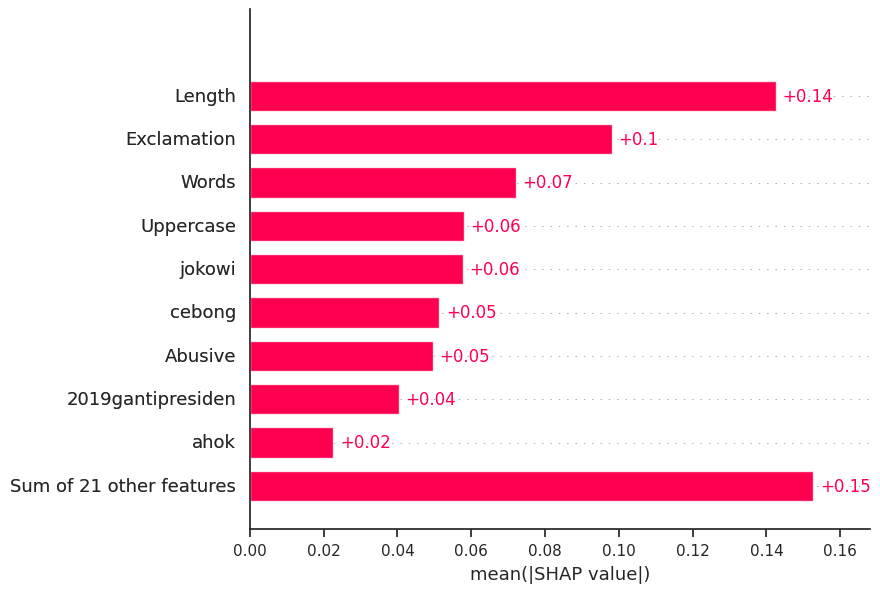

In [53]:
shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


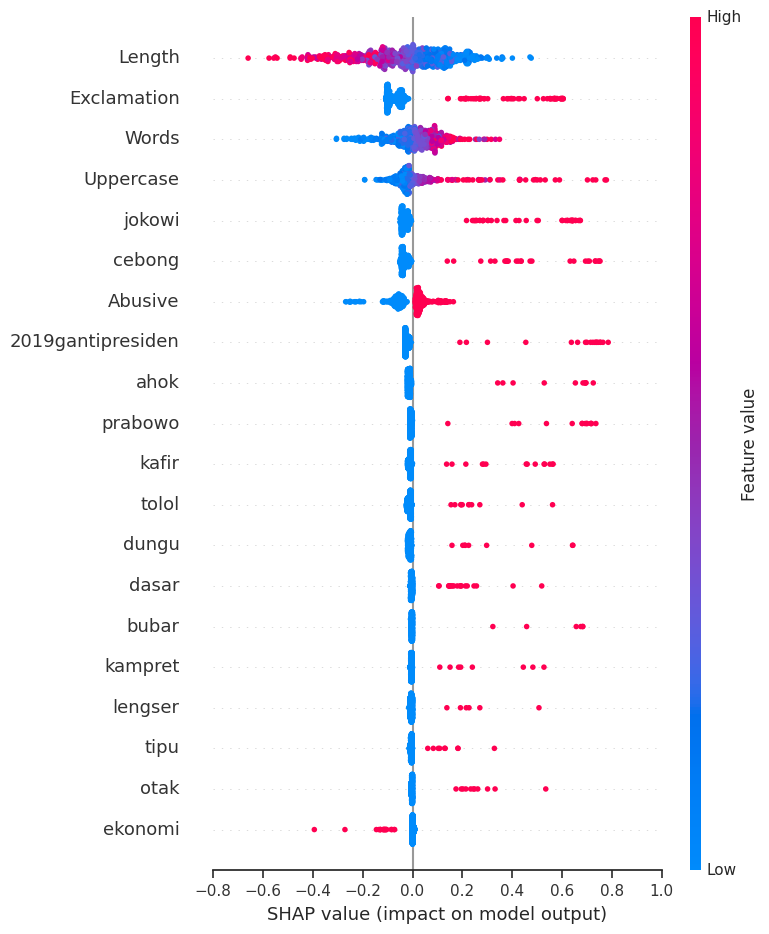

In [54]:
shap.summary_plot(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


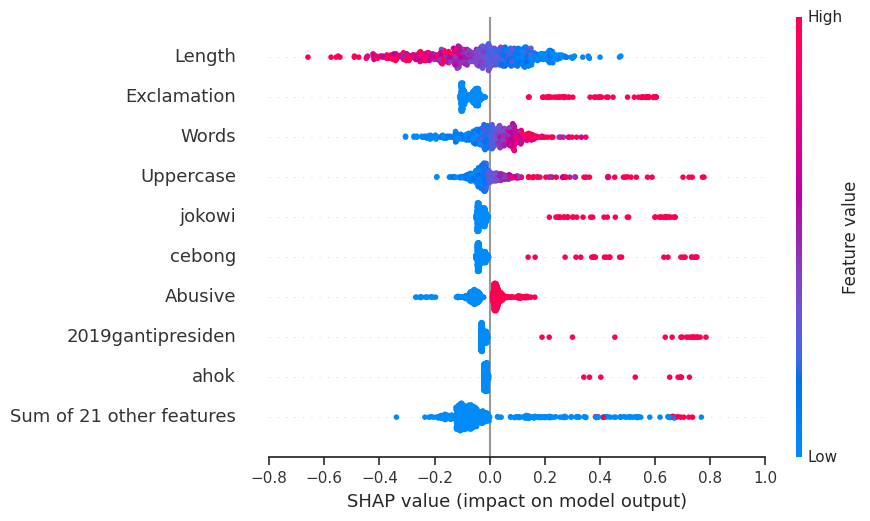

In [55]:
shap.plots.beeswarm(shap_values)#, X_test_array, feature_names=vectorizer.get_feature_names())

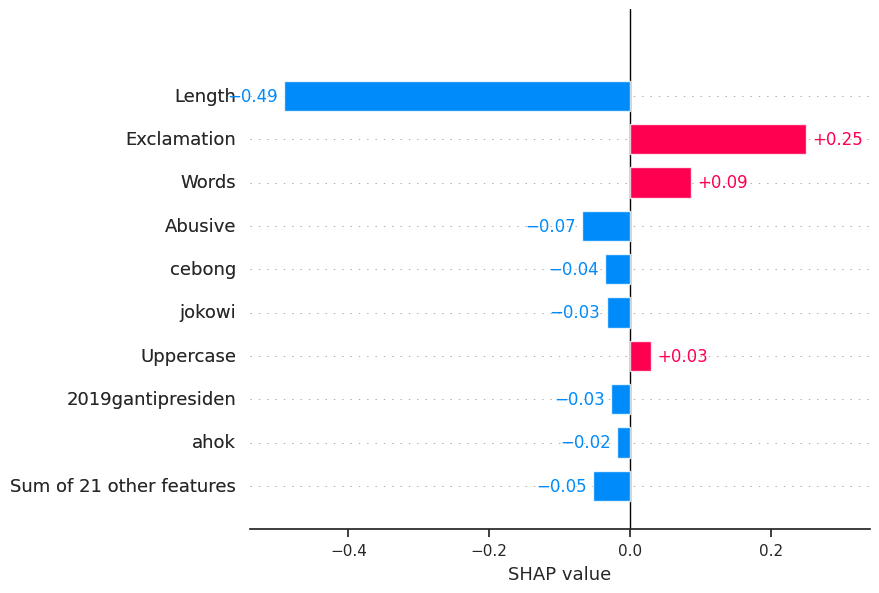

In [56]:
shap.plots.bar(shap_values[4])

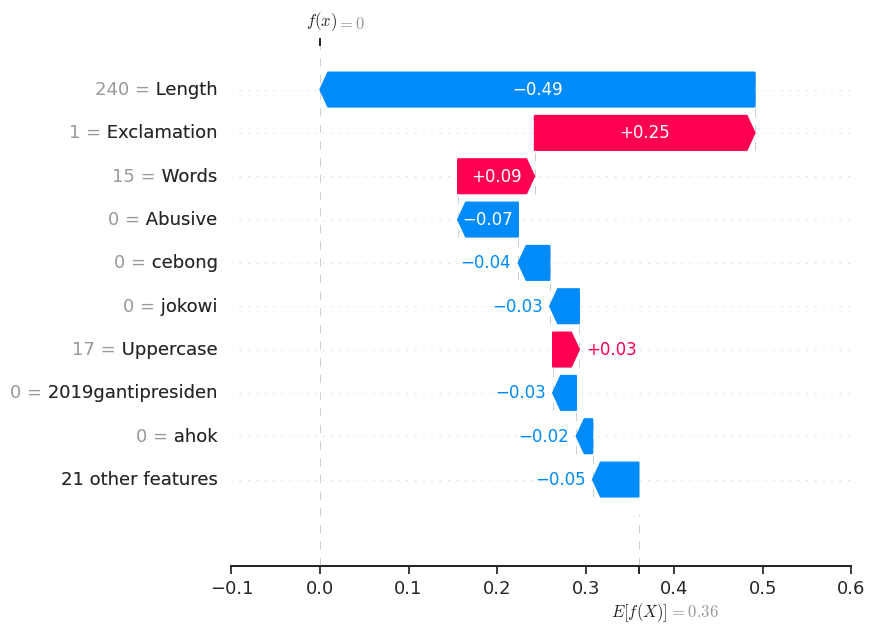

In [57]:
shap.plots.waterfall(shap_values[4])